<a href="https://colab.research.google.com/github/binodsth2/Blood_Sugar_Detection_using_machine_Learning/blob/main/Diabetes_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, validation_curve
import joblib

In [7]:
# Load your dataset
df = pd.read_csv('/content/sample_data/diabetes.csv')

In [8]:
# Display basic info
print("="*80)
print("DIABETES PREDICTION AND ANALYSIS SYSTEM")
print("="*80)

print("\n1. DATASET INFORMATION:")
print("-"*40)
df.info()

print("\n2. DATASET SHAPE:")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n3. COLUMN NAMES:")
print(df.columns.tolist())

print("\n4. MISSING VALUES:")
print(df.isnull().sum())

print("\n5. BASIC STATISTICS:")
print(df.describe())

DIABETES PREDICTION AND ANALYSIS SYSTEM

1. DATASET INFORMATION:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13

In [9]:
# Check for your target variable - adjust name if different
target_column = 'Diabetes_012'  # Change if your target has different name
print(f"\n6. TARGET VARIABLE DISTRIBUTION ({target_column}):")
target_counts = df[target_column].value_counts()
print(target_counts)


6. TARGET VARIABLE DISTRIBUTION (Diabetes_012):
Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


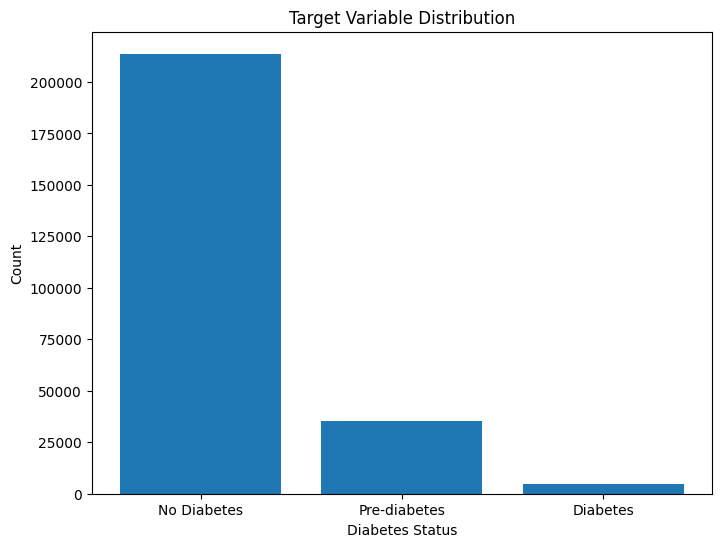

In [10]:
# Visualize target distribution
plt.figure(figsize=(8, 6))
plt.bar(['No Diabetes', 'Pre-diabetes', 'Diabetes'], target_counts.values)
plt.title('Target Variable Distribution')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.show()

In [11]:
# Check for any missing values
if df.isnull().sum().any():
    print("\nMissing values detected. Handling missing values...")
    df = df.fillna(df.mean())
    print("Missing values filled with column means.")

In [12]:
# Prepare features and target
x = df.drop(target_column, axis=1)
y = df[target_column]

print(f"\n7. FEATURE MATRIX SHAPE: {x.shape}")
print(f"TARGET VECTOR SHAPE: {y.shape}")



7. FEATURE MATRIX SHAPE: (253680, 21)
TARGET VECTOR SHAPE: (253680,)


In [13]:
# Check if your scatter plot columns exist
print("\n8. CHECKING FOR PLOTTING COLUMNS:")
available_columns = x.columns.tolist()
print(f"Available columns: {available_columns[:10]}...")  # Show first 10


8. CHECKING FOR PLOTTING COLUMNS:
Available columns: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies']...


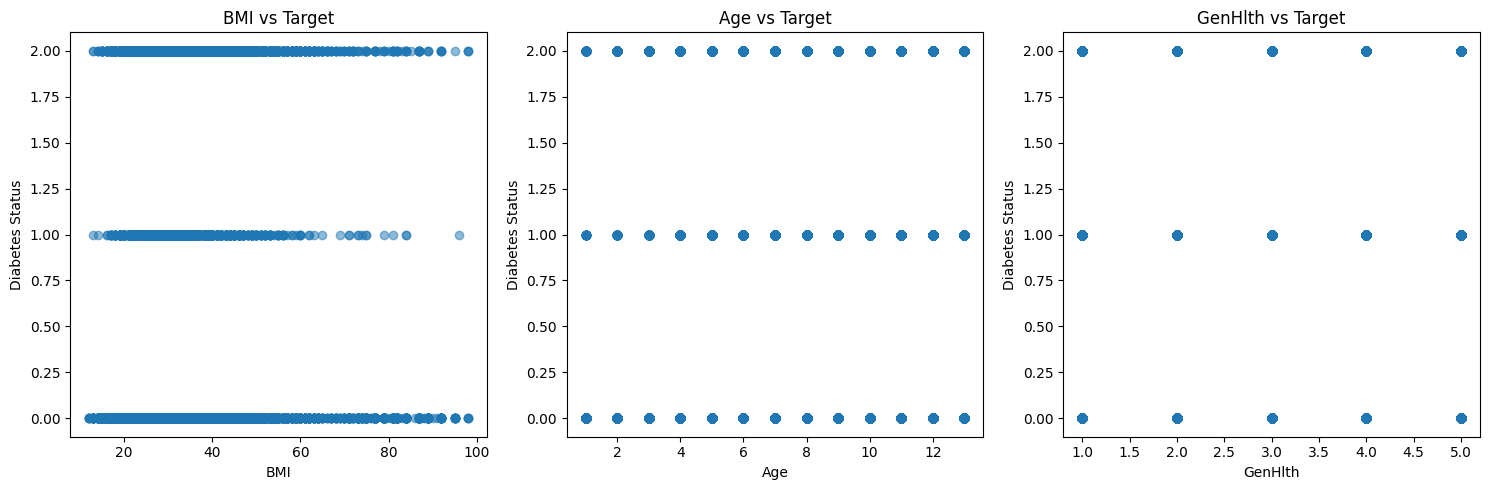

In [14]:
# Use available columns for scatter plot
scatter_cols = []
for col in ['BMI', 'Age', 'GenHlth']:  # Changed from your original selection
    if col in x.columns:
        scatter_cols.append(col)

if scatter_cols:
    # Create figure for scatter plots
    fig, axes = plt.subplots(1, len(scatter_cols), figsize=(15, 5))
    if len(scatter_cols) == 1:
        axes = [axes]

    for idx, col in enumerate(scatter_cols):
        axes[idx].scatter(x[col], y, alpha=0.5)
        axes[idx].set_title(f'{col} vs Target')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Diabetes Status')

    plt.tight_layout()
    plt.show()


9. FEATURE CORRELATION HEATMAP:


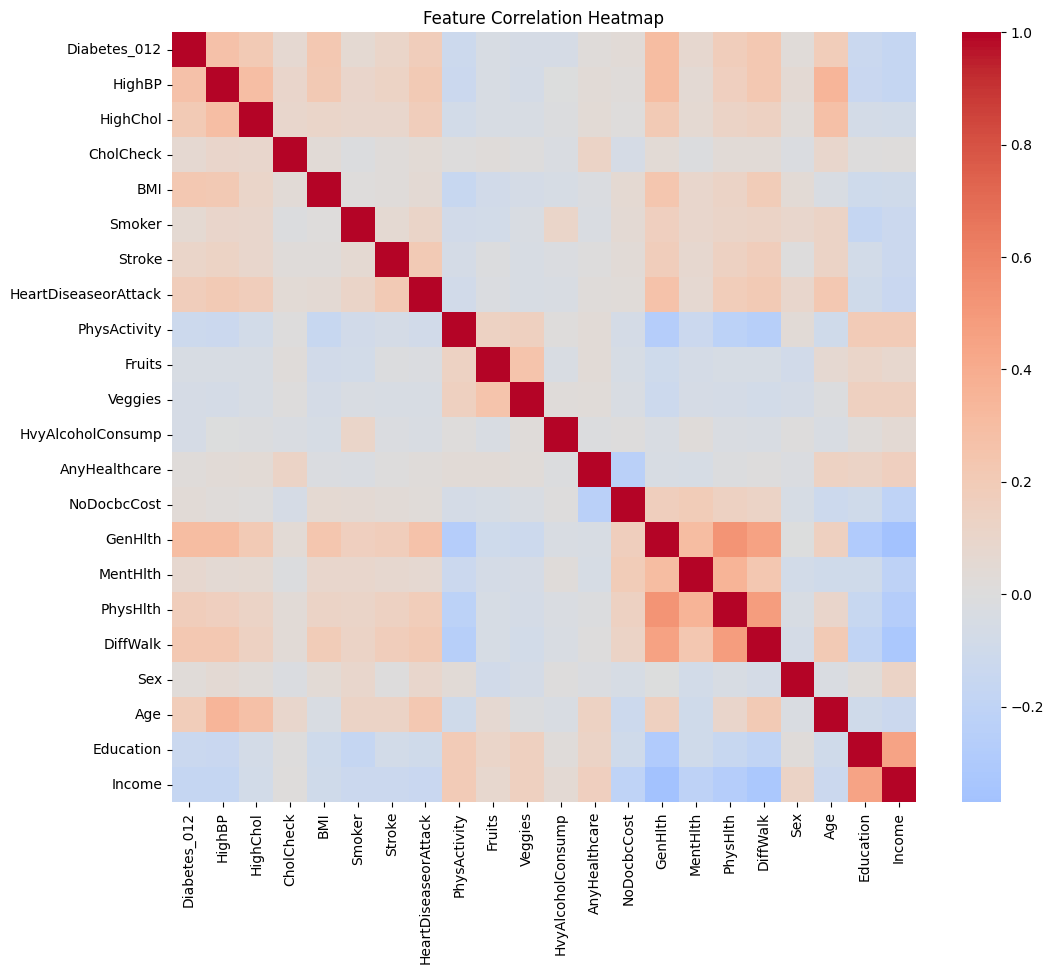

In [15]:
# Correlation heatmap
print("\n9. FEATURE CORRELATION HEATMAP:")
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [16]:
# Top correlations with target
if target_column in correlation_matrix.columns:
    target_correlations = correlation_matrix[target_column].abs().sort_values(ascending=False)
    print("\nTop 10 features correlated with target:")
    print(target_correlations.head(11)[1:])  # Skip the target itself


Top 10 features correlated with target:
GenHlth                 0.302587
HighBP                  0.271596
BMI                     0.224379
DiffWalk                0.224239
HighChol                0.209085
Age                     0.185026
HeartDiseaseorAttack    0.180272
PhysHlth                0.176287
Income                  0.171483
Education               0.130517
Name: Diabetes_012, dtype: float64


In [17]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n10. DATA SPLIT:")
print(f"Training set: {x_train.shape[0]} samples")
print(f"Testing set: {x_test.shape[0]} samples")


10. DATA SPLIT:
Training set: 202944 samples
Testing set: 50736 samples


In [18]:
# Scaling features
print("\n11. SCALING FEATURES...")
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


11. SCALING FEATURES...


In [19]:
# Display first few rows of scaled data
print("First 5 rows of scaled training data:")
print(pd.DataFrame(x_train_scaled, columns=x.columns).head())

First 5 rows of scaled training data:
     HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  \
0  1.153250 -0.858426   0.197488 -0.512552 -0.893675 -0.205655   
1 -0.867115 -0.858426   0.197488  1.301115  1.118975 -0.205655   
2  1.153250  1.164923   0.197488  0.998837 -0.893675 -0.205655   
3 -0.867115 -0.858426   0.197488 -0.210274 -0.893675 -0.205655   
4 -0.867115 -0.858426   0.197488 -0.059135  1.118975 -0.205655   

   HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  AnyHealthcare  \
0              -0.32264      0.567078  0.759080  0.481953  ...       0.227395   
1              -0.32264      0.567078  0.759080  0.481953  ...       0.227395   
2              -0.32264      0.567078  0.759080 -2.074891  ...       0.227395   
3              -0.32264      0.567078 -1.317384 -2.074891  ...       0.227395   
4              -0.32264      0.567078 -1.317384 -2.074891  ...       0.227395   

   NoDocbcCost   GenHlth  MentHlth  PhysHlth  DiffWalk       Sex       Age  \


In [20]:
# Label encoding for target
print("\n12. ENCODING TARGET VARIABLE...")
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Target encoding mapping:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")


12. ENCODING TARGET VARIABLE...
Target encoding mapping:
  0: 0.0
  1: 1.0
  2: 2.0


In [21]:
# Initialize models with improved parameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    #'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
}

print("\n13. TRAINING AND EVALUATING MODELS:")
print("-"*80)

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(x_train_scaled, y_train_encoded)

    # Make predictions
    y_pred = model.predict(x_test_scaled)
    y_pred_proba = model.predict_proba(x_test_scaled) if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")


13. TRAINING AND EVALUATING MODELS:
--------------------------------------------------------------------------------

Training Logistic Regression...
  Accuracy: 0.8455
  F1-Score: 0.8069
  Precision: 0.7977
  Recall: 0.8455

Training Random Forest...
  Accuracy: 0.8479
  F1-Score: 0.7975
  Precision: 0.8022
  Recall: 0.8479

Training XGBoost...
  Accuracy: 0.8496
  F1-Score: 0.8115
  Precision: 0.8053
  Recall: 0.8496

Training K-Nearest Neighbors...
  Accuracy: 0.8325
  F1-Score: 0.8025
  Precision: 0.7874
  Recall: 0.8325

Training Gradient Boosting...
  Accuracy: 0.8489
  F1-Score: 0.8110
  Precision: 0.8046
  Recall: 0.8489

Training AdaBoost...
  Accuracy: 0.8469
  F1-Score: 0.8124
  Precision: 0.8021
  Recall: 0.8469

Training Bagging Classifier...
  Accuracy: 0.8364
  F1-Score: 0.8086
  Precision: 0.7937
  Recall: 0.8364


In [22]:
# Create comparison DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results]
}).sort_values('Accuracy', ascending=False)

print("\n14. MODEL PERFORMANCE COMPARISON:")
print("-"*80)
print(results_df.to_string(index=False))


14. MODEL PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
              Model  Accuracy  F1-Score  Precision   Recall
            XGBoost  0.849555  0.811536   0.805265 0.849555
  Gradient Boosting  0.848944  0.810958   0.804593 0.848944
      Random Forest  0.847938  0.797505   0.802152 0.847938
           AdaBoost  0.846894  0.812394   0.802127 0.846894
Logistic Regression  0.845475  0.806922   0.797686 0.845475
 Bagging Classifier  0.836428  0.808584   0.793691 0.836428
K-Nearest Neighbors  0.832506  0.802527   0.787446 0.832506


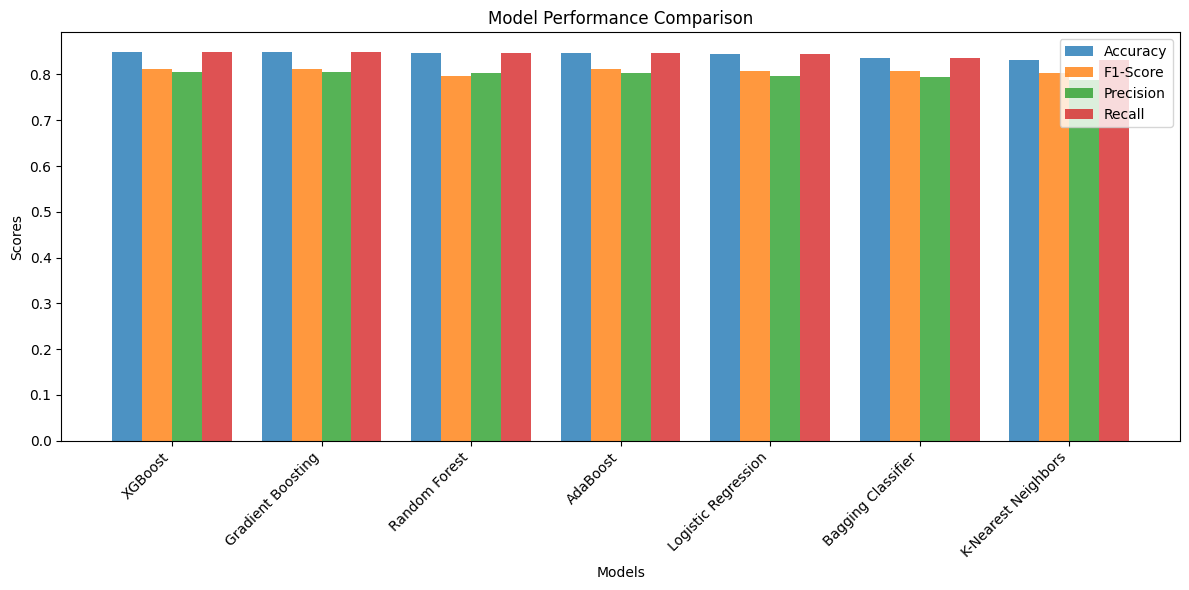

In [23]:
# Visualize model comparison
plt.figure(figsize=(12, 6))
x_pos = np.arange(len(results_df))
width = 0.2

plt.bar(x_pos - 1.5*width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x_pos - 0.5*width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
plt.bar(x_pos + 0.5*width, results_df['Precision'], width, label='Precision', alpha=0.8)
plt.bar(x_pos + 1.5*width, results_df['Recall'], width, label='Recall', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n15. BEST MODEL: {best_model_name}")
print(f"    Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")


15. BEST MODEL: XGBoost
    Accuracy: 0.8496


In [25]:
# Detailed evaluation of best model
print(f"\n16. DETAILED EVALUATION OF {best_model_name}:")
print("-"*80)

y_pred_best = results[best_model_name]['predictions']

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_best,
                           target_names=['No Diabetes', 'Pre-diabetes', 'Diabetes']))

print("Confusion Matrix:")
cm = confusion_matrix(y_test_encoded, y_pred_best)
print(cm)


16. DETAILED EVALUATION OF XGBoost:
--------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.86      0.98      0.92     42741
Pre-diabetes       0.00      0.00      0.00       926
    Diabetes       0.56      0.19      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.81      0.85      0.81     50736

Confusion Matrix:
[[41790     0   951]
 [  831     0    95]
 [ 5756     0  1313]]


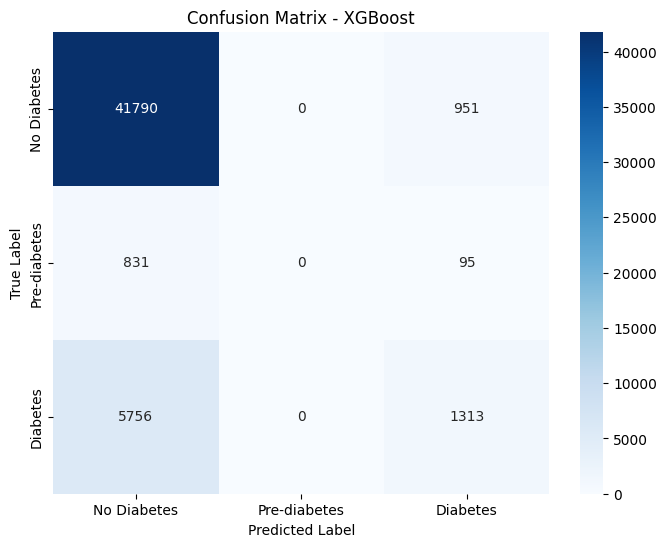

In [26]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Pre-diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


17. FEATURE IMPORTANCE:

Top 10 Important Features:
                 feature  importance
0                 HighBP    0.508323
13               GenHlth    0.135262
1               HighChol    0.077208
10     HvyAlcoholConsump    0.036811
2              CholCheck    0.035256
18                   Age    0.029686
3                    BMI    0.028349
6   HeartDiseaseorAttack    0.023719
16              DiffWalk    0.018165
17                   Sex    0.016316


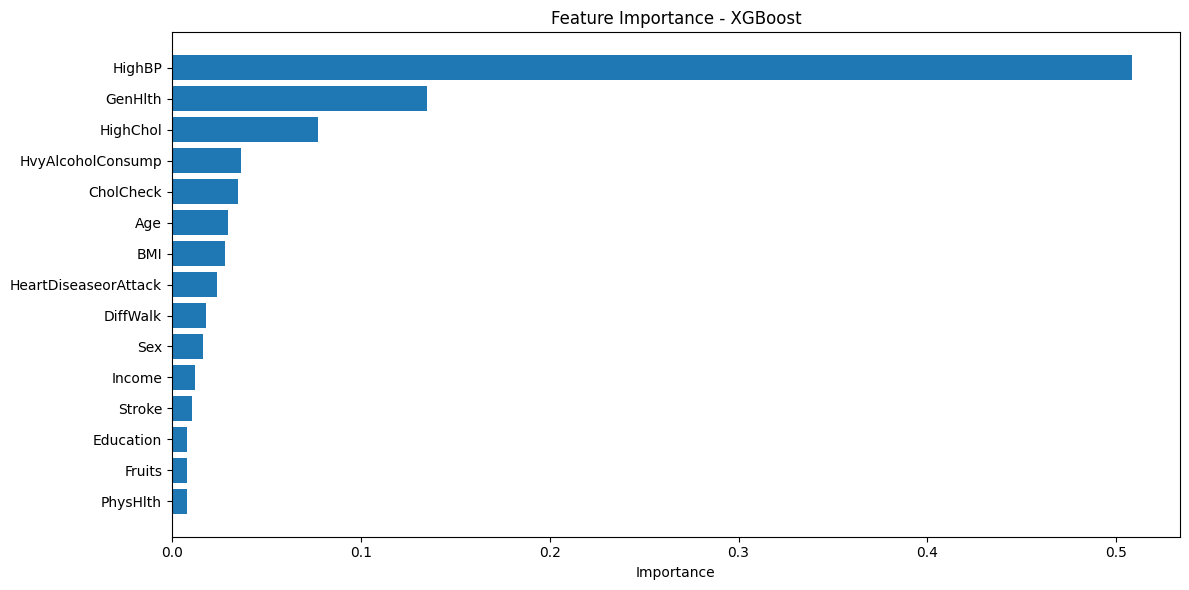

In [27]:
# Feature importance visualization
if hasattr(best_model, 'feature_importances_'):
    print("\n17. FEATURE IMPORTANCE:")
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': x.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Important Features:")
    print(feature_importance_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    top_features = feature_importance_df.head(15)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [28]:
# Save the best model and scaler
print("\n18. SAVING MODEL AND PREPROCESSORS...")
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("Model saved as 'best_diabetes_model.pkl'")
print("Scaler saved as 'scaler.pkl'")
print("Label encoder saved as 'label_encoder.pkl'")


18. SAVING MODEL AND PREPROCESSORS...
Model saved as 'best_diabetes_model.pkl'
Scaler saved as 'scaler.pkl'
Label encoder saved as 'label_encoder.pkl'


In [29]:
# Create prediction function
def predict_diabetes_risk(new_data, model=best_model, scaler=scaler, label_encoder=le):
    """
    Predict diabetes risk for new patient data

    Parameters:
    new_data: dict or pandas Series with feature values
    model: trained model
    scaler: fitted scaler
    label_encoder: fitted label encoder

    Returns:
    Dictionary with prediction and probabilities
    """
    # Convert to DataFrame
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = pd.DataFrame([new_data])

    # Ensure all columns are present
    for col in x.columns:
        if col not in new_df.columns:
            new_df[col] = x[col].median()  # Fill missing with median

    # Reorder columns
    new_df = new_df[x.columns]

    # Scale the data
    new_scaled = scaler.transform(new_df)

    # Make prediction
    prediction_encoded = model.predict(new_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]

    # Get probabilities if available
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(new_scaled)[0]
        prob_dict = {}
        for i, class_name in enumerate(label_encoder.classes_):
            prob_dict[class_name] = f"{probabilities[i]:.2%}"
    else:
        prob_dict = None

    # Create result dictionary
    result = {
        'prediction': prediction,
        'prediction_label': ['No Diabetes', 'Pre-diabetes', 'Diabetes'][prediction_encoded],
        'risk_level': ['Low', 'Medium', 'High'][prediction_encoded]
    }

    if prob_dict:
        result['probabilities'] = prob_dict

    return result

In [30]:
# Test prediction with example data
print("\n19. TESTING PREDICTION FUNCTION:")
print("-"*80)


19. TESTING PREDICTION FUNCTION:
--------------------------------------------------------------------------------


In [31]:
# Create example patient data based on your dataset columns
example_patient = {}
for col in x.columns:
    # Use median values for continuous features, mode for binary
    if df[col].nunique() == 2:  # Binary feature
        example_patient[col] = df[col].mode()[0]
    else:
        example_patient[col] = df[col].median()

In [32]:
# Make prediction
try:
    prediction_result = predict_diabetes_risk(example_patient)
    print(f"Example Prediction for Patient with Median Values:")
    print(f"  Prediction: {prediction_result['prediction_label']}")
    print(f"  Risk Level: {prediction_result['risk_level']}")
    if 'probabilities' in prediction_result:
        print(f"  Probabilities:")
        for risk, prob in prediction_result['probabilities'].items():
            print(f"    {risk}: {prob}")
except Exception as e:
    print(f"Prediction error: {e}")

Example Prediction for Patient with Median Values:
  Prediction: No Diabetes
  Risk Level: Low
  Probabilities:
    0.0: 96.96%
    1.0: 0.72%
    2.0: 2.32%


In [33]:
# Create comprehensive patient analysis function
def analyze_patient_health(patient_data):
    """
    Comprehensive health analysis for a patient
    """
    # Make prediction
    prediction = predict_diabetes_risk(patient_data)

    print("\n" + "="*80)
    print("COMPREHENSIVE PATIENT HEALTH ANALYSIS")
    print("="*80)

    print(f"\nDiabetes Risk Assessment:")
    print(f"  Risk Level: {prediction['risk_level']}")
    print(f"  Prediction: {prediction['prediction_label']}")

    if 'probabilities' in prediction:
        print(f"  Risk Probabilities:")
        for risk, prob in prediction['probabilities'].items():
            print(f"    {risk}: {prob}")

    # Identify key risk factors
    print(f"\nKey Risk Factors Detected:")

    risk_factors = []

    # Define risk thresholds
    if 'HighBP' in patient_data and patient_data.get('HighBP', 0) == 1:
        risk_factors.append("High Blood Pressure")
    if 'HighChol' in patient_data and patient_data.get('HighChol', 0) == 1:
        risk_factors.append("High Cholesterol")
    if 'BMI' in patient_data:
        bmi = patient_data['BMI']
        if bmi >= 30:
            risk_factors.append(f"Obesity (BMI: {bmi:.1f})")
        elif bmi >= 25:
            risk_factors.append(f"Overweight (BMI: {bmi:.1f})")
    if 'Smoker' in patient_data and patient_data.get('Smoker', 0) == 1:
        risk_factors.append("Smoking")
    if 'PhysActivity' in patient_data and patient_data.get('PhysActivity', 0) == 0:
        risk_factors.append("No Physical Activity")
    if 'GenHlth' in patient_data and patient_data.get('GenHlth', 0) >= 4:
        risk_factors.append("Poor General Health")

    if risk_factors:
        for i, factor in enumerate(risk_factors, 1):
            print(f"  {i}. {factor}")
    else:
        print("  No major risk factors detected")

    # Recommendations
    print(f"\nPersonalized Recommendations:")

    recommendations = []

    if 'BMI' in patient_data and patient_data.get('BMI', 0) > 25:
        recommendations.append("Consider weight management through balanced diet and regular exercise")

    if 'PhysActivity' in patient_data and patient_data.get('PhysActivity', 0) == 0:
        recommendations.append("Incorporate at least 150 minutes of moderate exercise weekly")

    if ('HighBP' in patient_data and patient_data.get('HighBP', 0) == 1) or \
       ('HighChol' in patient_data and patient_data.get('HighChol', 0) == 1):
        recommendations.append("Regular monitoring of blood pressure and cholesterol levels")

    if 'Smoker' in patient_data and patient_data.get('Smoker', 0) == 1:
        recommendations.append("Consider smoking cessation support programs")

    if 'Fruits' in patient_data and patient_data.get('Fruits', 0) == 0:
        recommendations.append("Increase fruit consumption for better nutrition")

    if 'Veggies' in patient_data and patient_data.get('Veggies', 0) == 0:
        recommendations.append("Increase vegetable intake for essential nutrients")

    if recommendations:
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec}")
    else:
        print("  Maintain current healthy lifestyle habits")

    # Next steps based on risk
    risk_level = prediction['risk_level']
    print(f"\nSuggested Next Steps:")

    if risk_level == 'Low':
        print("  • Annual comprehensive health checkup")
        print("  • Continue healthy lifestyle maintenance")
        print("  • Regular self-monitoring of key health indicators")
    elif risk_level == 'Medium':
        print("  • Bi-annual health monitoring (every 6 months)")
        print("  • Consider nutritional counseling")
        print("  • Regular exercise program with professional guidance")
        print("  • Monitor blood glucose levels periodically")
    else:  # High risk
        print("  • Immediate consultation with healthcare provider")
        print("  • Regular blood glucose monitoring (weekly or as advised)")
        print("  • Comprehensive diabetes management plan")
        print("  • Regular follow-ups with specialist")
        print("  • Consider medication if lifestyle changes are insufficient")

    return prediction

print("\n20. SYSTEM READY FOR PATIENT ANALYSIS")
print("="*80)


20. SYSTEM READY FOR PATIENT ANALYSIS


In [34]:
# Load saved model function
def load_saved_model():
    """Load saved model and preprocessors"""
    try:
        model = joblib.load('best_diabetes_model.pkl')
        scaler = joblib.load('scaler.pkl')
        le = joblib.load('label_encoder.pkl')
        print("Model and preprocessors loaded successfully!")
        return model, scaler, le
    except:
        print("Saved files not found. Using current session model.")
        return best_model, scaler, le

print("\nTo analyze a new patient, use:")
print("analyze_patient_health(patient_data_dict)")
print("\nExample patient data format:")
print("""
{
    'HighBP': 1,
    'HighChol': 1,
    'CholCheck': 1,
    'BMI': 35,
    'Smoker': 0,
    'Stroke': 0,
    'HeartDiseaseorAttack': 0,
    'PhysActivity': 0,
    'Fruits': 0,
    'Veggies': 1,
    'HvyAlcoholConsump': 0,
    'AnyHealthcare': 1,
    'NoDocbcCost': 0,
    'GenHlth': 4,
    'MentHlth': 10,
    'PhysHlth': 15,
    'DiffWalk': 1,
    'Sex': 0,
    'Age': 9,
    'Education': 4,
    'Income': 3
}
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE - MODEL READY FOR USE")
print("="*80)


To analyze a new patient, use:
analyze_patient_health(patient_data_dict)

Example patient data format:

{
    'HighBP': 1,
    'HighChol': 1,
    'CholCheck': 1,
    'BMI': 35,
    'Smoker': 0,
    'Stroke': 0,
    'HeartDiseaseorAttack': 0,
    'PhysActivity': 0,
    'Fruits': 0,
    'Veggies': 1,
    'HvyAlcoholConsump': 0,
    'AnyHealthcare': 1,
    'NoDocbcCost': 0,
    'GenHlth': 4,
    'MentHlth': 10,
    'PhysHlth': 15,
    'DiffWalk': 1,
    'Sex': 0,
    'Age': 9,
    'Education': 4,
    'Income': 3
}


ANALYSIS COMPLETE - MODEL READY FOR USE
